# PHYS 434 Lab 3 - Angela Zhou

In [1]:
# import the libraries
%matplotlib inline
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import hist
from matplotlib.pyplot import xticks
import scipy
from scipy import stats

from scipy.stats import norm
from scipy.stats import rayleigh
from scipy.stats import poisson

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (7,5)

## Problem 1
### Set up
### A) So our goal is to identify bad data and throw it out.
### 1. Start by exploring the data you have created with appropriate plots

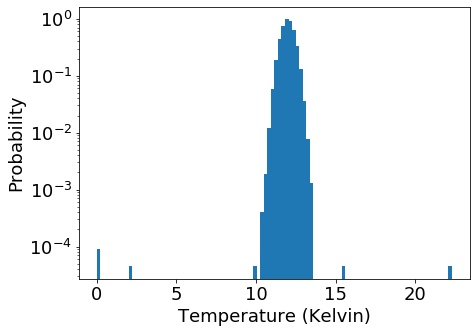

In [2]:
# Start by simulating 100k 'good' data points assuming Gaussian fluctations, and because we are playing god adding the following 'bad' datapoints: {10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7}
d = np.append(stats.norm.rvs(loc = 12., scale = 0.4, size = 100000), [10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7])
fig, ax = plt.subplots(1, 1)
ax.hist(d,100, density=True)
plt.tick_params(labelsize = 18)
plt.yscale('log')
#x = np.linspace(4.95,5.05,1000)
#ax.plot(x,stats.norm.pdf(x,loc = 5., scale = 0.01),linewidth = 8,alpha = 0.7)
plt.xlabel("Temperature (Kelvin)", fontsize = 18)
plt.ylabel("Probability", fontsize = 18)
plt.show()

### 2. State the statistical question in words. Be very clear, and describe why you have chosen this statistical question.

The statistical question is: Between 0 and what value of sigma of this distribution is our data still good and was not created when the thermal control system wasn't working? Or what is the value of significance in this distribution when we start to consider the data points we got to be bad data and are excluding them from our statistics? <br>
I chose this statistical question based on the goal we are trying to accomplish. Essentially, we are trying to identify the bad data caused by thermal control system misbehave and throw it out. 

### 3. Restate your question in math. Be very clear.

Looking at the background distribution above, we can identify some bad data points. What are the sigma values corresponding to bad data points? <br>
First we need to integrate the pdf of this background distribution from some bad data point(candidate) we pick. I chose x = 15 as my candidate. Depending on whether this candidate point is to the left or right of the mean, we might choose to integrate the pdf from negative infinity or to positive infinity to get an equally or more signal-like signal from this background distribution. For integrating from negative infinity to candidate point, use norm.sf(candidate); to integrate from candidate point to positive infinity, use norm.cdf(candidate). Since my candidate is x = 15, it is to the right of the mean(x = 12), I will use norm.sf(15) to integrate from x = 15 to positive infinity and get the probability. <br>
Once we have the probability from the last step, we can convert that probability to sigma using norm.ppf(1-probability). This should give us the sigma value for the candidate. Any point that has a sigma value greater than or equals to the sigma we get in this step is consider to be the bad data and are therefore excluded from the analysis.

### 4. Apply your statistical test and construct a truth table.

In [3]:
## Calculate the sigma value where we consider data to be bad
# pick a candidate for bad data
candidate = 15

# generate the pdf for our background distribution
x = np.linspace(0,25,100)
pdf = norm.pdf(x, loc = 12., scale = 0.4)
# plt.plot(x,pdf) # plot to check the pdf

# calculate the probability at the candidate
# integrate using .sf() from candidate to positive infinity since the candidate is to the right of the mean
probability = norm.sf(candidate, loc = 12., scale = 0.4)
print(probability) # print out p to check if it makes sense

# convert p to sigma
sigma_threshold = abs(norm.ppf(1-probability,loc = 12., scale = 0.4))
print(sigma_threshold) # print out sigma to check

3.1908916729108844e-14
15.000074842841451


In [4]:
## make a new distribution d_new w/o bad data
# create a new np array to store a new distribution w/o bad data
d_new = np.empty(0)
# looping through all entries in d and calculate sigma for each entry
# if abs(sigma) >= sigma_threshold -> that data point is bad
for i in d:
    # computer probability
    if (i < 12) : # if data point is on the left side of the mean
        p = norm.cdf(i, loc = 12., scale = 0.4)
    else: # data point is on the right side of the mean
        p = norm.sf(i, loc = 12., scale = 0.4)
        
    # convert p to sigma
    s = abs(norm.ppf(1-p, loc = 12., scale = 0.4))
    if(s < sigma_threshold):
        d_new = np.append(d_new, i)
        
#     print(p)
#     print(s)


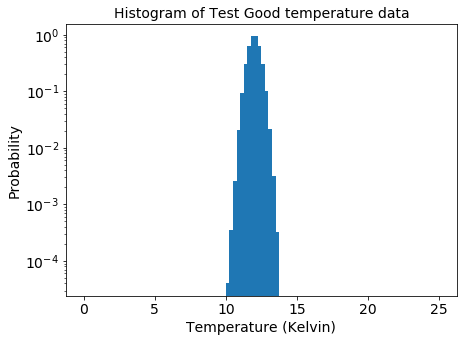

In [5]:
plt.hist(d_new,100, density = True, range = (0,25));
plt.yscale("log");
plt.tick_params(labelsize = 14);
plt.xlabel("Temperature (Kelvin)", fontsize = 14);
plt.ylabel("Probability", fontsize = 14);
plt.title("Histogram of Test Good temperature data", fontsize = 14);

This histogram above is what the background data distribution looks like after I throw out the bad data using the algorithm described above. <br>
Now, in the cell below, I will start calculating the entries for the truth table.

In [6]:
## calculating entries for the truth table

# first, since we know all the bad data points in this case, store them in a np array
badData = np.array([10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7])

# initialize some useful ints
TT_total = 100000
BT_total = badData.size
t_11 = 0 # entry 11 in the truth table
t_12 = 0
t_21 = 0
t_22 = 0

# Check if any good data got eliminated
for i in d_new: # looping through all entries in the new distribution d_new
    if (i in badData): # bad data got included in d_new -> Bad T got Test Good
        t_12 = t_12 + 1
    if ((i in d) and (i not in badData) and (i not in d_new)) : # if an entry is a good data but it's identified as bad and is not included in d_new
        t_21 = t_21 + 1
        
t_22 = BT_total - t_12
t_11 = TT_total - t_21

print(t_11, t_12)
print(t_21, t_22)

100000 3
0 5


|  | True T | Bad T |
| :-: | :-: | :-: |
| Your Test Good | 100000 | 3 |
| Your Test Bad | 0 | 5 |

The idea is how often you kept the known good data (True T & Your Test Good), how often you correctly discarded bad data (Bad T & Your Test Bad), and how often mistakes were made of either omission or commission (off diagonals). <br>
From the truth table above we can see that this algorithm works pretty well with keeping the known good data on this data set. The True T & Test Good is 100000 which is all the good data we have. None of the good data points got identified as bad data. However, among all 8 bad data points, it discarded 5 of them and kept 3 bad data points in the distribution. <br>
The sum of the off diagonal elements is 3. Considering there are 100008 data points in total with 100000 good data points and 8 bad data points, I think this algorithm works pretty well in general. 

### B) How does the number of omissions, where you threw out good data, depend on the statistical threshold you chose and is it a predictable quantity?

The statistical threshold I chose in the algorithm above is when x = 15 for a Gaussian distribution with mean = 12. <br>
The number of omissions is a predictable quantity depending on hte statistical threshold we choose. The further my threshold point is from the mean, a larger sigma value it will have, and the less good data will get throw out, the smaller the number of omissions. 

### C) Are there mistakes of commission (bad data getting in)? If yes, are they avoidable and how do they depend on your statistical threshold?

Yes, there are mistakes of commission. From the truth table above, we can see there are 3 mistakes of commission happened among 100008 data points in total with 8 bad data.<br>
Mistakes of commission are aboidable; the smaller statistical threshold we choose, the less mistakes of commission there will be. <br>
Although sometimes the trade off of getting less mistakes of commission is having more number of omissions. <br>
If the threshold is set to a very small value, the chances of making mistakes of commission is low, but at the same time the number of omissions will be a lot higher. If the threshold is set to infinity, all the data points will be included, we get a low number of omissions but there will also be a lot of mistakes of commission. 

## Problem 2
### Set up: A 2D Gaussian with 1 arcsecond RMS

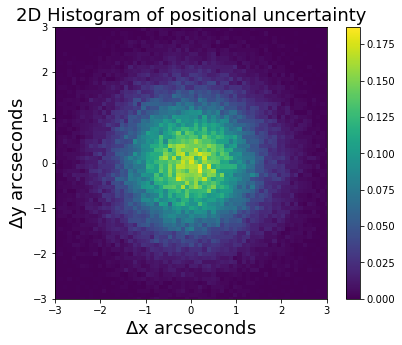

In [7]:
a = np.vstack((stats.norm.rvs( scale = 1, size = 100000), stats.norm.rvs( scale = 1, size = 100000)))
a.shape
fig, ax = plt.subplots(1, 1)
h = ax.hist2d(a[0,:],a[1,:],bins=100, density=True);
ax.set_aspect('equal', 'box')
plt.xlim([-3 , 3])
plt.ylim([-3 , 3])
plt.title("2D Histogram of positional uncertainty", fontsize = 18);
plt.ylabel("$\Delta$y arcseconds", fontsize = 18);
plt.xlabel("$\Delta$x arcseconds", fontsize = 18);
plt.colorbar(h[3], ax=ax);

### If I have a potential asteroid, it will have some true movement between the images. We would like a '5 sigma' detection of movement. What is that distance in arcseconds?
### 1. What is the question in words?

The statistical question in words is: What is the distance signal required for a 5-sigma detection in this 2D gaussian distribution?

### 2. What is the question in math? [Hint: Come up with an analytic description of your pdf(). The Blue Book may be helpful here.]

First, we need to find the pdf of the background distribution above. This distribution is a 2D gaussian with x axis corresponds to star movement in x direction, y axis corresponds to star movement in y direction. The magnitude of the vector with x y represents the distance of the movement. Based on the physical meaning, we identify the pdf of this distribution to be a Rayleigh distribution. <br>
Then, we need to create the pdf based on the Rayleigh distribution; the x values of this pdf are distances. We need to find the x value in this pdf that corresponds to 5 sigma. The result will be the distance that has a "5 sigma" detection of movement.<br>
We can convert 5 sigma to probability using norm.sf() to integrate the normal sigma distribution from 5 to positive infinity. After having the probability, we can then use rayleigh.isf(probability) which is the inverse survival function to find the signal corresponds to that probability. The result we get will be the distance for a 5-sigma dectection of motion in this problem.

### 3. What distance in arcseconds represents a 5 sigma detection of motion?

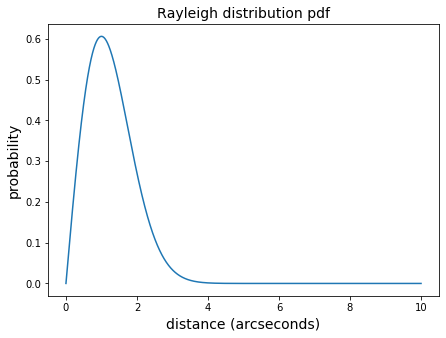

In [8]:
# create a pdf based on rayleigh
x = np.linspace(0,10,10000)
pdf = rayleigh.pdf(x)
plt.plot(x,pdf);
plt.xlabel("distance (arcseconds)", fontsize = 14);
plt.ylabel("probability", fontsize = 14);
plt.title("Rayleigh distribution pdf", fontsize = 14);

In [9]:
# convert 5 sigma to probability
p = norm.sf(5)
print(p)

# convert probability to signal
signal = rayleigh.isf(p) # .isf() is the inverse of .sf()
print("The distance that represents a 5 sigma detection of motion is " + str(signal) + " arcseconds.")

2.866515718791933e-07
The distance that represents a 5 sigma detection of motion is 5.489079776062419 arcseconds.


## Problem 3
### Assume in a moon sized patch on the sky we normally have a cosmic ray rate of 1 cosmic ray per minute (arrivals are random in time). If we can observe where the moon is for 8 hours per night (not too close to the horizon) and we observe for 15 days and see 6800 cosmic rays, what is the signficance of our moon shadow detection?
### 1. What is the question in words?

We expect to detect 1 cosmic ray per minute, and we observe for 15 days, 8 hours per night, that's 15 * 8 * 60 = 7200 minutes of observation. The 7200 minutes of observation is the background distribution, and we observed a signal of 6800 cosmic rays. What is the probability that the data produces a signal that is equally or more signal-like than what I observed?

### 2. Translate the question to math, describing both the expected background pdf() and the integral you need to do.

Due to the nature of this setup, we have an expected signal for every minute and we observe for 7200 minutes to get a background distribution, we expect the background pdf to be a non-continuous distribution. Then, among all non-continuous distributiosn, based on the meaning of each distribution, we can see that the Poisson distribution best describes the expected background pdf in this case. <br>
Poisson distribution is a discrete distribution that expresses the probability of a given number of events occurring in a fixed interval of time assuming these events occur with a known constant mean rate and independently of the time since the last event. <br>
For 1 minute, the background pdf has a Poisson distribution with mean = 1. To get the background pdf for 7200 minutes, we need to convolve the background pdf for 1 minute 7200 times. The result of this convolution will still be a Poisson distribution but with a different mean, mean = 7200. <br>
After having the background pdf for 7200 minutes, we can then find the probability of our observation 6800 cosmic rays in this background distribution by integrating from negative infinity or to positive infinity depending on whether 6800 is to the left of the mean or to the right of the mean. 6800 < 7200, our observation is to the left of the mean, therefore, we need to integrate from negative infinity to 6800 using poisson.cdf(6800). <br>
poisson.cdf(6800) gives a probability. We then need to convert this probability to sigma using poisson.ppf(probability) to find the significance of our observation 6800 cosmic rays.


### 3. Convert to sigma.

In [10]:
# create a poission distribution for 1 minute
k = range(0,10)
background_1 = poisson.pmf(k,mu = 1)
background_2 = poisson.pmf(k,mu = 1)
# plt.hist(background_1)

# convolve the distribution for 1 minute 7200 times to get the distribution for 7200 minutes
minutes = 7200
for i in range(minutes):
    pdf = np.convolve(background_1,background_2)
    background_1 = pdf


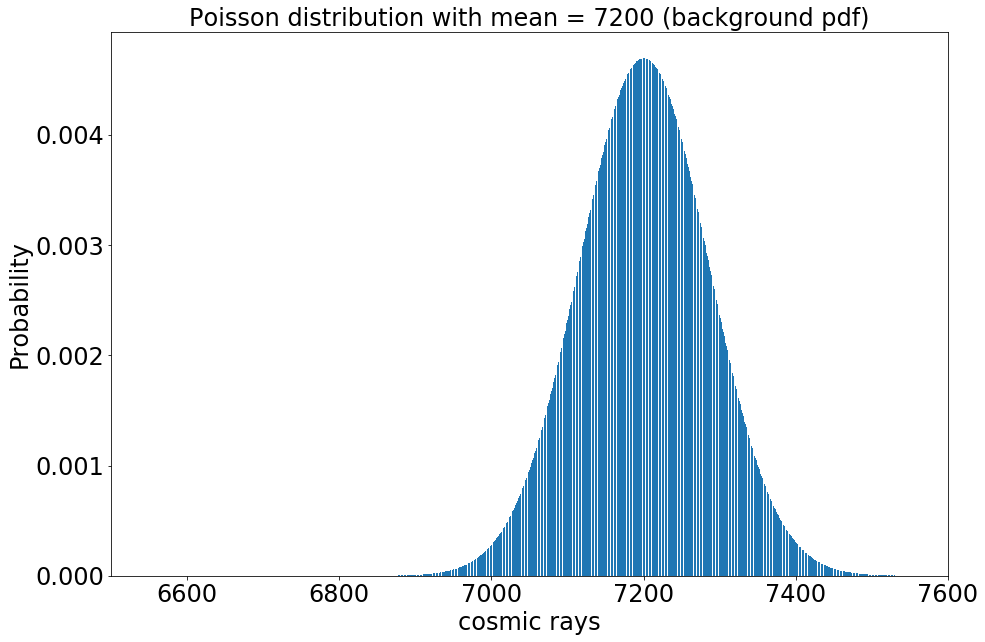

In [11]:
# this sets the size of the plot 
plt.rcParams["figure.figsize"] = (15,10)

# sets discrete x values for the bar plot
xrange = range(0,64810) 

fig, ax = plt.subplots(1, 1) # create a figure
plt.tick_params(labelsize = 24) # sets tick parameter for the plot, in this case, the label size
plt.xlim([6500,7600]) # sets rage for x axis
ax.bar(xrange, pdf) 
ax.set_title("Poisson distribution with mean = 7200 (background pdf)", fontsize = 24)
ax.set_xlabel("cosmic rays",fontsize = 24)
ax.set_ylabel("Probability", fontsize = 24)
plt.show()

In [12]:
# calculate the probability of 6800 cosmic rays by integrating from negative infinity to 6800
p = poisson.cdf(k = 6800, mu = 7200)

# convert probability to sigma
sigma = norm.ppf(p)

print("The significance of our moon shadow detection(6800 cosmic rays) is "+ str(abs(sigma)) + " sigma.")

The significance of our moon shadow detection(6800 cosmic rays) is 4.750747965777188 sigma.
